In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image as im
from scipy.ndimage import interpolation as inter

from IPython.display import display

In [2]:
input_file = sys.argv[1]
display(input_file)

'-f'

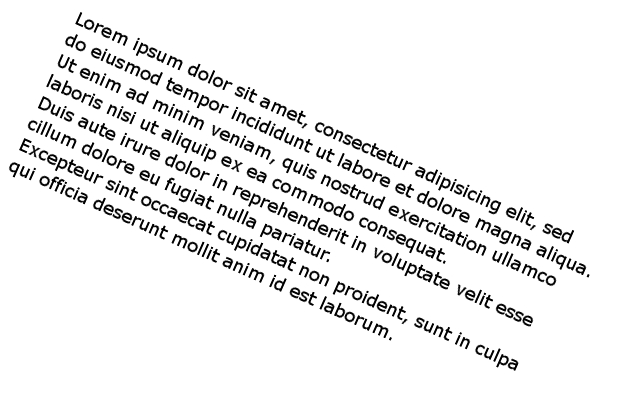

In [3]:
img = im.open("img.jpg")
display(img)

# 1 - Convert to binary

In layman’s terms Binarization means converting a coloured image into an image which consists of only black and white pixels (Black pixel value=0 and White pixel value=255). As a basic rule, this can be done by fixing a threshold (normally threshold=127, as it is exactly half of the pixel range 0–255). If the pixel value is greater than the threshold, it is considered as a white pixel, else considered as a black pixel.

In [4]:
wd, ht = img.size
display(f"width {wd}px - hight {ht}px")

'width 640px - hight 400px'

In [5]:
pix = np.array(img.convert("1").getdata(), np.uint8)

display(pix.shape)
pix

(256000,)

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [6]:
bin_img = 1 - (pix.reshape((ht, wd)) / 255.0)

display(bin_img.shape)
bin_img

(400, 640)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

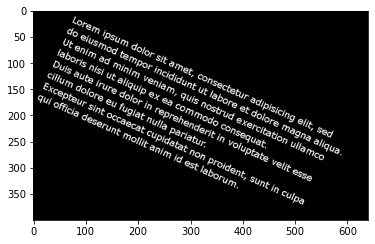

In [7]:
plt.imshow(bin_img, cmap="gray")
plt.savefig("binary.png")

# 2 - Skew Correction

While scanning a document, it might be slightly skewed (image aligned at a certain angle with horizontal) sometimes. While extracting the information from the scanned image, detecting & correcting the skew is crucial.

Several techniques are used for skew correction.

- → Projection profile method
- → Hough transformation method
- → Topline method
- → Scanline method

However, the projection profile method is the simplest, easiest and most widely used way to determine skew in documents.

In [8]:
def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

delta = 1
limit = 360

angles = np.arange(-limit, limit + delta, delta)
scores = []

for angle in angles:
    hist, score = find_score(bin_img, angle)
    scores.append(score)
    
best_score = max(scores)
best_angle = angles[scores.index(best_score)]

print("Best angle: {}".format(best_angle))
print(f"Best score {best_score} \t Best angle {best_angle}")

Best angle: -336
Best score 735528.0 	 Best angle -336


### correct skew

In [9]:
data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
img = im.fromarray((255 * data).astype("uint8")).convert("RGB")
img.save("skew_correction.png")

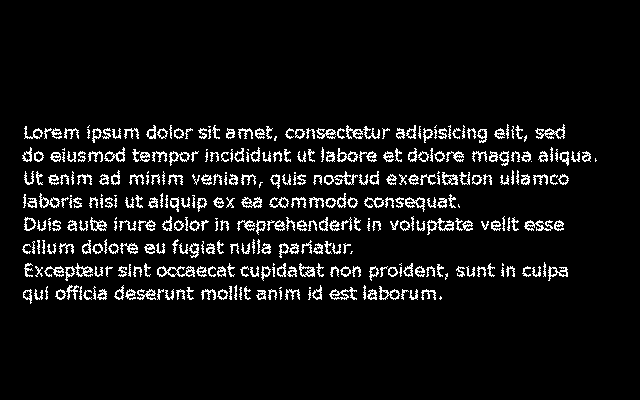

In [10]:
img

# 3 - Noise Removal

The main objective of the Noise removal stage is to smoothen the image by removing small dots/patches which have high intensity than the rest of the image. Noise removal can be performed for both Coloured and Binary images.
One way of performing Noise removal by using OpenCV fastNlMeansDenoisingColored function

In [11]:
import cv2

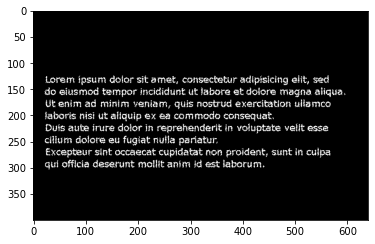

In [15]:
# reading image
img = cv2.imread("skew_correction.png")

# denoising the img saving it into dst img
dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(dst)
plt.show()

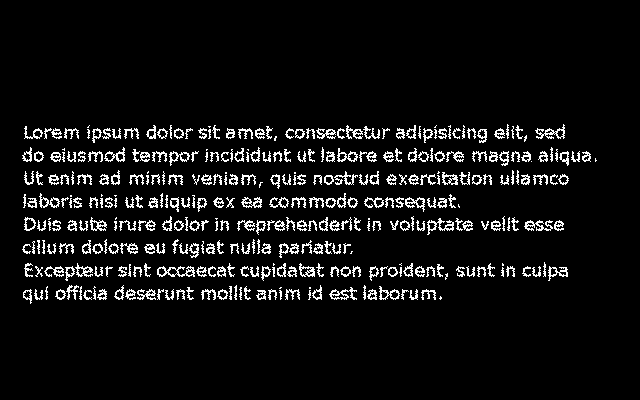

In [24]:
no_noise_img = im.fromarray((dst).astype("uint8")).convert("RGB")
no_noise_img.save("no_noise_img.png")
no_noise_img

# 4 - Thinning and Skeletonization

This is an optional preprocessing task which depends on the context in which the OCR is being used.

- → If we are using the OCR system for the printed text, No need of performing this task because the printed text always has a uniform stroke width.

- → If we are using the OCR system for handwritten text, this task has to be performed since different writers have a different style of writing and hence different stroke width. So to make the width of strokes uniform, we have to perform Thinning and Skeletonization.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [32]:
img = cv2.imread("no_noise_img.png", 0)

kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(img, kernel, iterations=1)

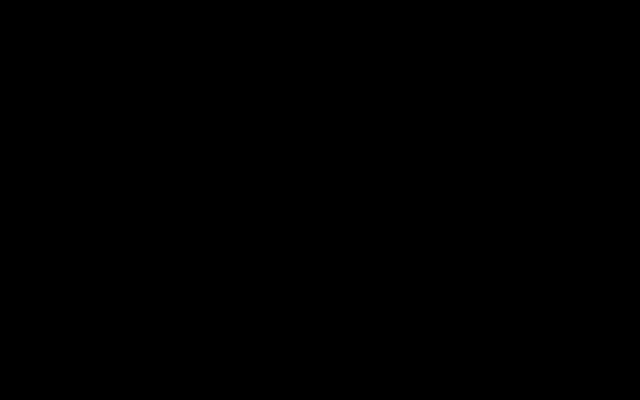

In [33]:
im.fromarray((erosion).astype("uint8")).convert("RGB")

# Segmetation

Is nothing but the breaking the whole image into subparts to process them further

Segmentation of image is done in the following sequence :
- → Line level Segmentation
- → Word level Segmentation
- → Character level Segmentation

### Horizontal Histogram Projection: 

In this method, we count the No.of foreground pixels along the rows of the image, and the resultant array is of the size equal to No.of rows in the image (Height of the image).